In [1]:
import json
import pickle
import re
import collections
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from random import randint
import sys
import math
from scipy import spatial

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
ff_path = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\ff_of_rep\\'
path = 'C:\\Users\\chenwang\\Documents\\courses\\FA16\\CS597\\twitterMining\\InitialSet\\Football\\location\\'

In [3]:
with open (path + 'candidate_100.pickle','rb') as f:
    candidate_list = pickle.load(f)

In [4]:
# open features
with open (path + 'represent_id.pickle','rb') as f:
    feature = pickle.load(f)

In [5]:
len(candidate_list)

7529

# construct a vector

In [6]:
def construct_vector(candidate_list,feature):
    
    V = dict((c,np.zeros(len(feature),)) for c in candidate_list)

    for i in range(len(feature)):  
        with open(ff_path + str(feature[i]) + '.pickle','rb') as f:

                candidate = pickle.load(f)

                for c in candidate:
                    if c in V.keys():
                        #print('true')
                        V[c][i] = 1 
    return V

In [7]:
Vector = construct_vector(candidate_list,feature)
len(Vector)

7529

# test block to see how sparse the matrix is

In [8]:
def test_sparsity(V,feature_num):
    for v in list(V.keys()):
        total_feature = np.sum(V[v])
        if total_feature >= feature_num:
            print('user_id:', v,'\t\ttotal feature:', total_feature)
    return None

In [9]:
test_sparsity(Vector,40)

user_id: 791068282736484352 		total feature: 49.0
user_id: 781149191808712704 		total feature: 46.0


# estimate prior
<img src= 'prior.png'>

i feel like this prior wont affect ranking so can be omit, doesnt change with Ux

In [10]:
with open(path + 'prob_following_rep.pickle','rb') as f:
    prob = pickle.load(f)

# Build Classifier
<img src=untitled.png>

In [11]:
def rank_candidate(V, feature):
    candidate_score = {}

    for v in list(V.keys()):  # for each user
        
        score = 0
        for i in range(len(feature)): # for each feature            

            if V[v][i] == 1:  # if follow
                score += math.log2(prob[0][i]) # ln(p(follow)) 

            elif V[v][i] == 0:
                score += math.log2(prob[1][i]) # ln(p(unfollow))

        candidate_score[v] = score
    
    candidate_score_ranked = sorted(candidate_score.items(),key=lambda x:x[1],reverse=True)
    
    return candidate_score_ranked

In [12]:
c_rank = rank_candidate(Vector, feature)
len(c_rank)

7529

In [ ]:
with open (path + 'NB_ranked_100.pickle', 'wb+') as f:
    pickle.dump(c_rank,f)

In [26]:
def plot_ranks(rank,Vector,extra_xlabel):
    
    n_f = []  # total number of features
    for c in rank:
        n_f.append(np.sum(Vector[c[0]]))

    x = range(1,len(n_f)+1)
    y = n_f

    fig, axes = plt.subplots(figsize=(10,10))

    axes.plot(x,y)
    axes.set_xlabel('ranked candidate ' + extra_xlabel)
    axes.set_ylabel('total number of feature')
    axes.set_title('total candidate:' + str(len(c_rank)))
    #axes.set_ylim([1,40])
    #axes.set_xlim([0,30000])

    plt.show()

    return n_f

In [ ]:
tot_f_num = plot_ranks(c_rank,Vector,'(Naive Bayes)')

# Vector space model approach
similarity = cosine similarity?


In [13]:
with open(path + 'weight_rep.pickle','rb') as f:
    weight_vector = pickle.load(f)

In [21]:
def cosine_similarity(V, weight):
    similarity = {}
    feature_vector = np.ones((1,100))
    #print(feature_vector)
                      
    for v in list(V.keys()):  # for each user
        if weight != None:
            V_weighted = np.multiply(V[v],weight_vector)
            similarity[v] = 1 - spatial.distance.cosine(V_weighted, weight)
        else:
            similarity[v] = 1 - spatial.distance.cosine(V[v],feature_vector)

    sim_ranked = sorted(similarity.items(),key=lambda x:x[1],reverse=True)
    
    return sim_ranked

In [15]:
weighted_sim_ranked = cosine_similarity(Vector,weight_vector)

In [17]:
weighted_sim_ranked[:10]

[(754013832108994560, 0.81915218511226695),
 (781149191808712704, 0.80697806279668594),
 (787488684912156672, 0.79923621341870432),
 (751010271880151040, 0.79215972545784552),
 (4422065969, 0.77809750039113568),
 (791068282736484352, 0.77615998210576131),
 (779659530242142208, 0.7741969648956134),
 (2792235196, 0.74965471154004859),
 (4284918074, 0.71983991404675729),
 (725426517459628032, 0.71490228546887591)]

In [19]:
with open(path + 'weighted_sim_ranked_100.pickle','wb+') as f:
    pickle.dump(weighted_sim_ranked,f)

In [22]:
sim_ranked = cosine_similarity(Vector, None)

In [23]:
sim_ranked[:10]

[(791068282736484352, 0.69999999999999996),
 (781149191808712704, 0.67823299831252681),
 (785599640146108417, 0.59160797830996159),
 (779659530242142208, 0.5830951894845301),
 (788347210698256384, 0.5830951894845301),
 (787488684912156672, 0.56568542494923801),
 (550557628, 0.55677643628300222),
 (790322349098749952, 0.55677643628300222),
 (787676699240570880, 0.55677643628300222),
 (780206098431213568, 0.55677643628300222)]

In [29]:
with open(path + 'unweighted_sim_ranked_100.pickle','wb+') as f:
    pickle.dump(sim_ranked,f)

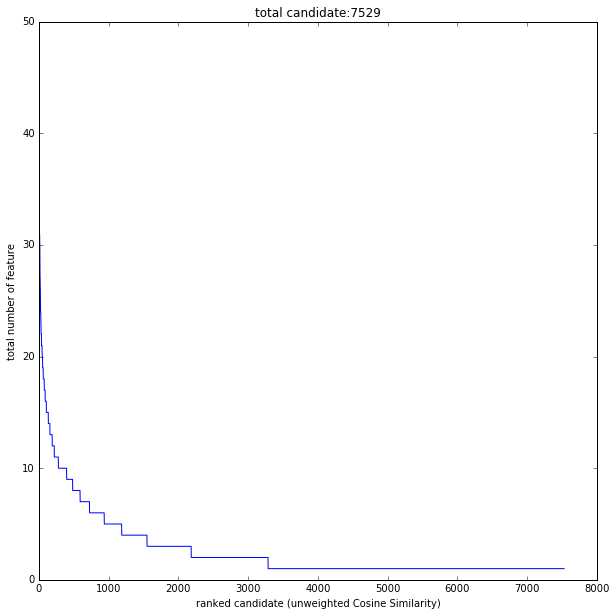

In [30]:
tot_f_num = plot_ranks(sim_ranked,Vector,'(unweighted Cosine Similarity)')

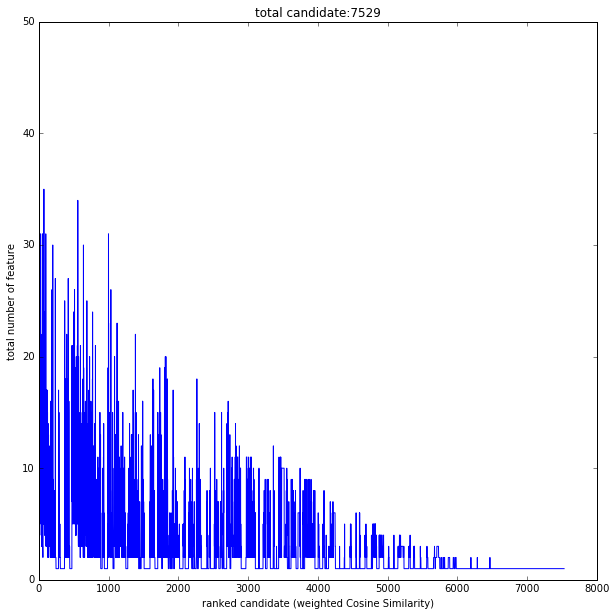

In [28]:
tot_f_num = plot_ranks(weighted_sim_ranked,Vector,'(weighted Cosine Similarity)')

# questions: 

begining of Oct

1. for initial list:
I applied very stringent approach (only look at user profile who provides 'chicago' as their location). Reasonable? Extra learning required?

2. feature selection:
How many representative nodes do we need?

3. feature ranking:
My approach reasonable? Any improvement?

4. rate limit problem
when use the clf on test data, need to retrieve test nodes's friends_list. thus only can test a small portion once a time.
can't be real time very slow

5. is this approach generic enough? 
chicago is famous. What if it's non-famous? what if it's smaller or bigger area?

6. How to utilize the query user by keyword?

7. How to test the performance? 
We hae ground truth (a small portion of user will list their profile location <10%)

# Things to do:
a. SVD rank feature 

b. haven\'t add prior to naive bayes

c. think!

I have different goal than Amin's approach.
--------------------------------------------------------------------------------------------------------
representatives:
(1) Amin's approach is very time consuming, might hit a lot of rate limit. imagine loop over 150,000+ people, query their followers to get the "follower number"
(2) filter the top 200 frequent "TF" potential candidate by their location? might sacrifice some representatives that doesn't explicitly list their location? Still consuming, hit rate limit 

Difference of Amin's goal and my goal
he wants to find interest, i want to find location. I have more information than he has. How can I utilize these information.